In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


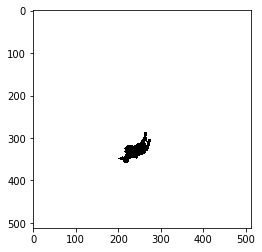

In [27]:
import matplotlib.pyplot as plt

img_path = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/imgs/0001863_shadow.png'
img = plt.imread(img_path)
plt.imshow(img)

In [28]:
import torch
import ssn_dataset
from torchvision import transforms, utils
import numpy as np

csv_file = "~/Dataset/soft_shadow/train/metadata.csv"
# compose_transform = None
training_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = True)
testing_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = False)

print('training set size: ', len(training_dataset))
print('testing set size: ',len(testing_dataset))

print(len(training_dataset.meta_data))
print(training_dataset.meta_data[0])

# for j in range(10):
#     for i in range(len(training_dataset)):
#         data = training_dataset[i]
# #         print("{} \r".format(i), flush=True, end="")
#         print("{} ".format(i))
    
# for i,data in enumerate(testing_dataset):
#     print("{} \r".format(i), flush=True, end="")

Dataset initialize spent: 3.651726007461548 ms
Dataset initialize spent: 3.1080474853515625 ms
training set size:  102643
testing set size:  10264
228096
['/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C'
 '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/imgs/0001863_mask.png'
 '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/imgs/0001863_shadow.png'
 '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/imgs/0001863_light.png'
 '0_1.48623_1.81262' "['180']" '0.221693_3.073748_-0.84722300208424']


In [29]:
import sys
sys.path.append("..")
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import random

def reset_seed(id):
    np.random.seed(int(time.time()) + id * 11234)
    random.seed(int(time.time()) + id * 11234)
    
dataloader = DataLoader(training_dataset, batch_size=8, shuffle=True, num_workers=16, worker_init_fn=reset_seed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


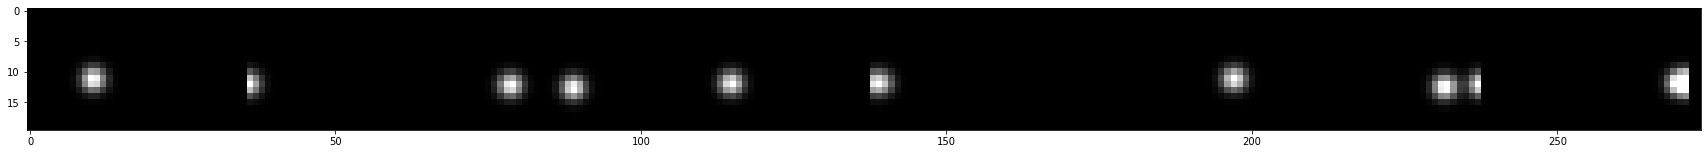

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


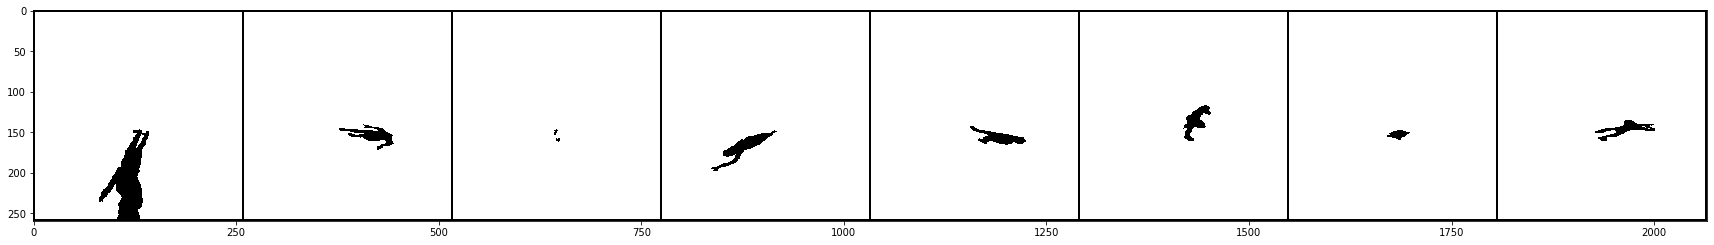

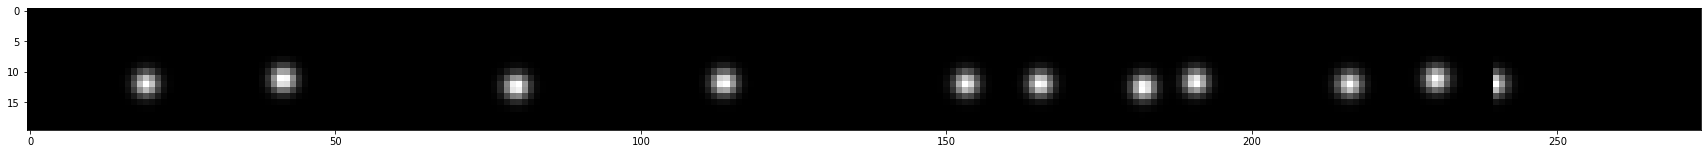

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


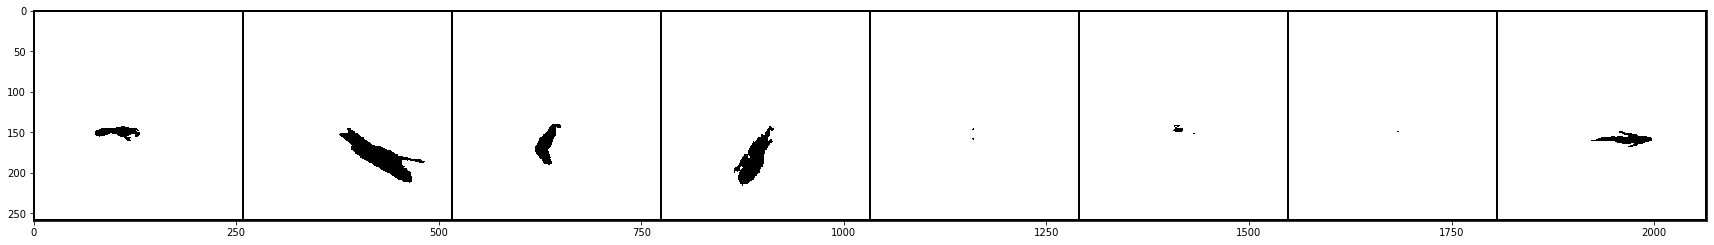

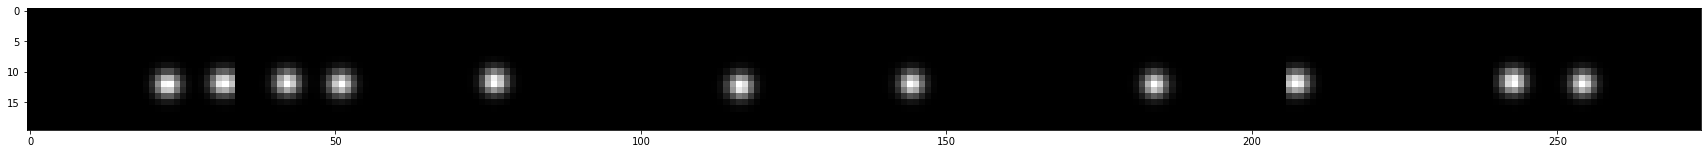

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


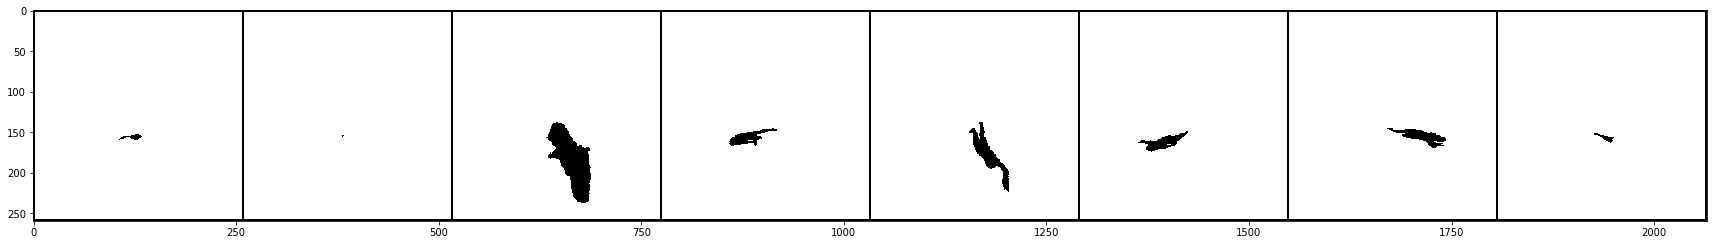

In [30]:
def vis_light(light_tensor):
    channel = light_tensor.size()[0]
    tensor_ret = torch.zeros(light_tensor.size())
    for i in range(channel):
        light_np = light_tensor[0].numpy()
        # print('max: ', np.max(light_np))
        # print('min: ', np.min(light_np))
        # light_np = gaussian_filter(light_np * 100.0, sigma=3)/np.max(light_np)
        tensor_ret[i] = torch.from_numpy(light_np) 
    return tensor_ret

for i, (mask, light, shadow) in enumerate(dataloader):
    # print(torch.max(light))
    
    # concatenate human mask and shadow mask
    I_s, L_t, I_t = mask, light, shadow
    
    # print('light size: ', light.size())
    # show_batch(I_s)
    show_batch(L_t)
    
    b,c,h,w = I_t.shape
#     for i in range(b):
#         I_t[i] = I_t[i]/torch.max(I_t[i])
        
#     I_t = I_t/torch.max(I_t)
#     print(torch.max(I_t))
    show_batch(I_t)
    
    if i > 1:
        break
    
#     human_gt = I_t[:,0,:,:]
#     shadow_gt = I_t[:,1,:,:]
    
#     batch_size, c, h, w = I_t.size()
#     human_mask, shadow_mask = torch.zeros(batch_size, h, w, dtype= torch.float32), torch.zeros(batch_size, h, w, dtype= torch.float32)
#     human_mask[torch.where(human_gt !=0)] = 1
#     shadow_mask[torch.where(shadow_gt !=0)] = 1
    
# #     print(human_mask.size())
# #     print(shadow_mask.size())
    
#     show_batch(human_mask.view(batch_size, 1, h, w))
#     show_batch(shadow_mask.view(batch_size, 1, h, w))
    
#     zero = torch.zeros(batch_size, h, w, dtype= torch.float32)
    
# #     print(human_gt.size())
# #     print(torch.where(human_gt !=0)[0].size())
# #     print(torch.where(human_gt ==0)[0].size())
    
#     weight = torch.where(human_gt ==0)[0].size()[0]/ float(torch.where(human_gt !=0)[0].size()[0]) 
#     pos_weight = torch.ones(human_mask.size())
#     pos_weight[torch.where(human_gt !=0)] = weight
    
    
    # print(criterion(zero, human_mask))

In [ ]:
import seaborn 
import torch
import numpy as np
from scipy.ndimage.filters import gaussian_filter

def to_numpy_img(t):
    t_np = t.numpy()
    t_np = np.transpose(t_np, (1,2,0))
    return t_np

test_tensor = torch.zeros(9,256, 256)
test = to_numpy_img(test_tensor)
test[128, 128, 0] = 1

test_ = gaussian_filter(test, sigma = 10)
seaborn.heatmap(test[:,:,0])
seaborn.heatmap(test_[:,:, 0])

In [ ]:
import torch
import matplotlib.pyplot as plt
import math

# todo, vectorize this process
test_torch = torch.zeros(16,32)
for h in range(test_torch.size()[0]):
    test_torch[h,:] = abs(math.sin(h / 16.0 * 3.1415926)) + 0.001

test_np = test_torch.detach().cpu().numpy()

plt.figure()
plt.imshow(test_np,cmap='gray')light_np

In [ ]:
from ssn_submodule import Up
import torch

x1 = torch.randn(1,512, 16,16)
x2 = torch.randn(1,256, 32,32)

model = Up(512,256)
out = model(x1,x2)
print(out.size())

In [ ]:
data_file = '/home/ysheng/Dataset/soft_shadow/single_human/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/ground_truth.txt'

with open(data_file,'r') as f:
    content = f.readlines()

lines = [c.strip() for c in content]
data_num = int(len(lines)/6)

def get_pos(pos_str):
    x = float(pos_str[1])
    y = float(pos_str[2])
    z = float(pos_str[3])
    return np.array([x,y,z])

def get_spherical(pos):
    x,y,z = pos
    alpha = np.arctan2(z,x)
    beta = np.arctan2(y, np.sqrt(x**2 + z**2))
    return alpha, beta

prefix_list, alpha_list, beta_list = [], [], []
for i in range(data_num):
    prefix_str = lines[6 * i + 0]
    human_pos_str = lines[6 * i + 3].split()
    light_pos_str = lines[6 * i + 4].split()
    human_pos = get_pos(human_pos_str)
    light_pos = get_pos(light_pos_str)
    
    light_dir = light_pos - human_pos
    light_dir_norm = light_dir/np.linalg.norm(light_dir, 2)
    alpha, beta = get_spherical(light_dir_norm)
    # print('alpha: {}, beta: {} \n'.format(alpha, beta))
    alpha_list.append(alpha + np.pi)
    beta_list.append(beta + np.pi)    
    prefix_list.append(prefix_str)
    
alpha_ary = np.array(alpha_list)
beta_ary = np.array(beta_list)

In [ ]:
from PIL import Image

def compute_IBL(alpha, beta):
    h, w = 256, 256
    IBL = np.zeros((h,w))
    
    two_pi = 2.0 * np.pi
    alpha_coord, beta_coord = int(w * alpha/two_pi), int(h * beta/two_pi)
    IBL[beta_coord, alpha_coord] = 1.0
    return IBL

def show_gau_light(ibl):
    light_np = gaussian_filter(ibl, sigma=3)/np.max(ibl)
    plt.figure(figsize=(10,6))
    plt.imshow(light_np)

for i in range(6400):
    ibl = compute_IBL(alpha_ary[i], beta_ary[i])
    show_gau_light(ibl)

    light_img = '{}/{}_light.png'.format('/home/ysheng/Dataset/soft_shadow/single_human/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A',prefix_list[i])
    # light_img_np = np.array(Image.open(light_img).resize((32,32)))
    light_img_np = np.array(Image.open(light_img))
    show_gau_light(light_img_np)
    
    if i > 10:
        break